# 토픽 모델링

## 1. 데이터 불러오기 및 전처리

In [13]:
import numpy as np
import random
import os

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(2021)

In [14]:
import pandas as pd

data = pd.read_csv('review_checked_final.csv', encoding='utf-8')

In [7]:
data

,title,review_checked
0,(무삭제) 귀멸의 칼날,사실 만화가 명작이라기보단 유포 더블이 레전드다 하는 게 더 옳음 사실 만화의 전개...
1,(무삭제) 귀멸의 칼날,이걸 굳이 잔인하게 만들어서 세 걸어 놓은 이유랑 왤캐 인기가 많은지 모르겠네 그냥...
2,(무삭제) 귀멸의 칼날,나도 귀탈 나쁘지 않게 킬링 욕으로 봤는데 귀탈이 강연 진격을 넘는다는 이상한 말만...
3,(무삭제) 귀멸의 칼날,욕먹고 망해가는 작품을 애니가 살림 연출 작화 사운드 모두 만점이지만 진부한 전개와...
4,(무삭제) 귀멸의 칼날,솔직히 애니는 진짜 잘 만들었다 작화도 좋고 액션 연출 브금 타이밍까지 잘 만든 애...
...,...,...
168424,소나기,이거 학교에서 보여줬는데 눈물은 안 났음
168425,소나기,솔직히 연출이나 이어나가는 스토리가 그렇게 자연스러운 편이 아니라고 생각함 근데 너...
168426,소나기,보고 싶다
168427,소나기,일단 개인적인 생각인데 설명이 좀 부족한 것 같음 갑작스러운 연출도 적지 않게 있기...


In [15]:
from konlpy.tag import Komoran
from konlpy.tag import Okt
from konlpy.tag import Hannanum

okt = Okt()
han = Hannanum()
komo = Komoran()
stopwords = stopwords = ['애니', '감사', '이랑', '생각', '이건', '극장판', '마지막', '정도', '때문', '정주', '기대', '일본', '최고','이번','멤버','사랑','천관','사복','소장','판권','화성','사랑','모자이크','사랑해','다음','한국','중국']


# 명사 2글자 이상
def tokenize(doc):
    wordlist = []
    for word in komo.nouns(doc):
      if len(word) > 1 and word not in stopwords:
         wordlist.append(word)
    return(wordlist)

In [16]:
#토큰화
token_data=[] 

for value in data['review_checked']:
    tok = tokenize(value)
    token_data.append(tok)

In [24]:
len(token_data)

168429

In [25]:
drop_corpus = []

for corpus in token_data:
    if len(set(corpus)) < 3:   # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set()을 사용
        drop_corpus.append(corpus)
    
for corpus in drop_corpus:
    token_data.remove(corpus)

In [26]:
len(token_data)

79802

In [65]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

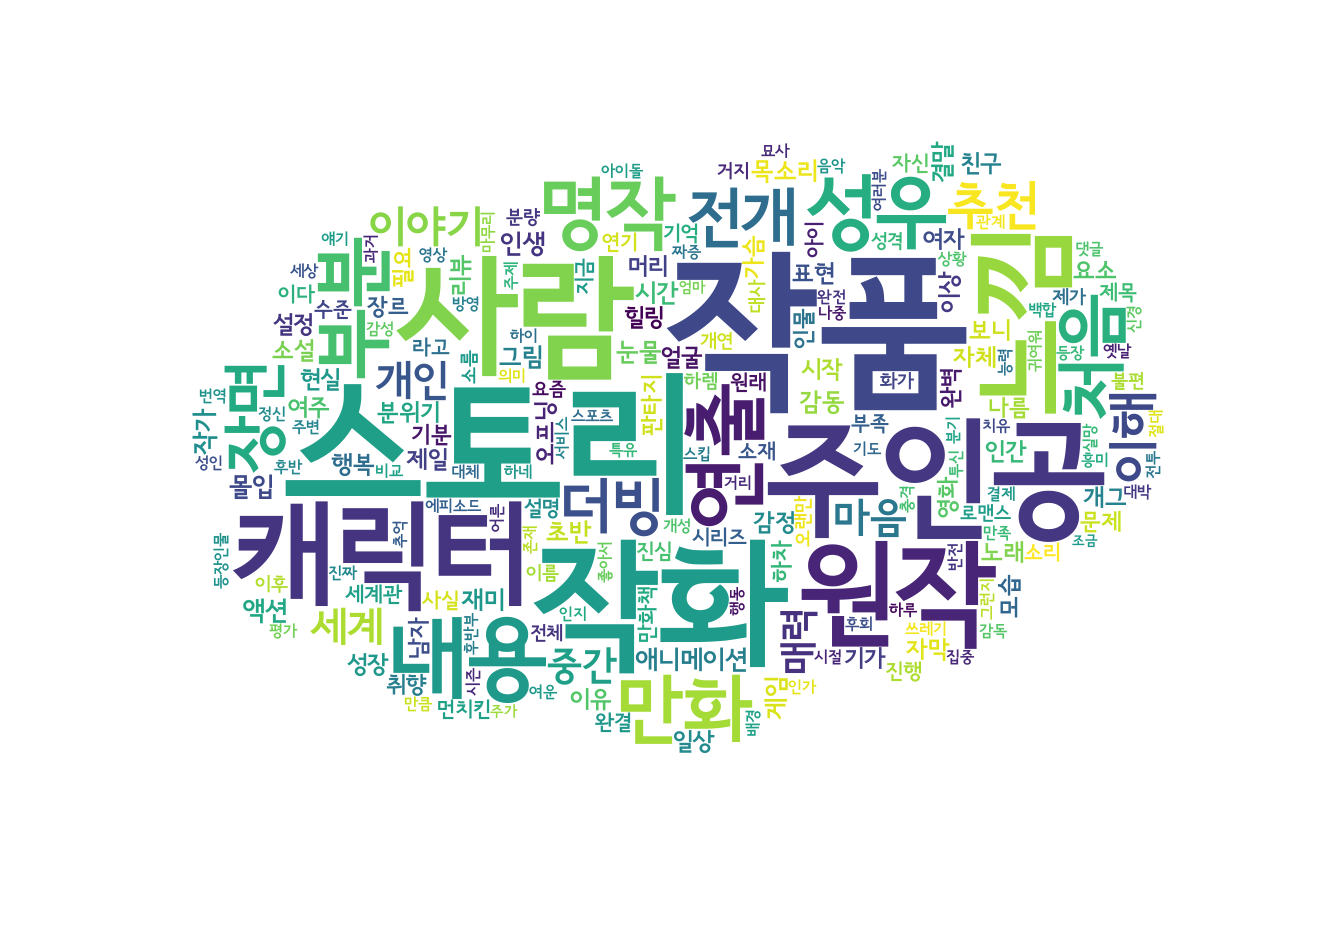

In [92]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

token_flatten = flatten_list(token_data)
count = Counter(token_flatten)
noun_list = count.most_common()
mask = np.array(Image.open('cloud.png')) # 마스크 이미지 생성
wc = WordCloud(font_path='08SeoulNamsanEB.ttf',background_color="white", 
               width = 800, height=400, mask=mask, random_state=42)
wc.generate_from_frequencies(dict(noun_list))


wc.to_image()

## 2. LDA 파라미터 튜닝

In [29]:
#BoW
from gensim import corpora
dictionary = corpora.Dictionary(token_data)
corpus = [dictionary.doc2bow(text) for text in token_data]
print(corpus[0])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1)]


In [14]:
#TF-IDF
from gensim import corpora, models
dictionary = corpora.Dictionary(token_data)
corpus = [dictionary.doc2bow(text) for text in token_data]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [27]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

### 2-1. epoch반복횟수 설정

In [20]:
coherences=[]
perplexities=[]

for i in range(10):   
    ntopics = 10
    if i==0:
        p=1
    else:
        p=i*5
    lda = LdaModel(corpus, id2word=dictionary, num_topics=ntopics, passes=p, random_state=2021)
    print('epoch',p)

    cm = CoherenceModel(model=lda, texts=token_data, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda.log_perplexity(corpus),'\n\n')
    perplexities.append(lda.log_perplexity(corpus))

epoch 1
Cpherence 0.31601998915322005
Perplexity:  -8.82034748608752 


epoch 5
Cpherence 0.3221410082314183
Perplexity:  -8.701739704708281 


epoch 10
Cpherence 0.3234521209952218
Perplexity:  -8.682284827410108 


epoch 15
Cpherence 0.3277897602534715
Perplexity:  -8.667668077498535 


epoch 20
Cpherence 0.32727530445190317
Perplexity:  -8.657247483674528 


epoch 25
Cpherence 0.334830279972817
Perplexity:  -8.649383939090981 


epoch 30
Cpherence 0.33806576896500784
Perplexity:  -8.640745088459292 


epoch 35
Cpherence 0.3361746526773234
Perplexity:  -8.63333276785484 


epoch 40
Cpherence 0.33708719753509053
Perplexity:  -8.628091406291082 


epoch 45
Cpherence 0.33708719753509053
Perplexity:  -8.62259111234303 




Text(0, 0.5, 'perplexity score')

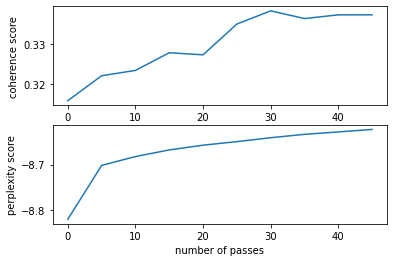

In [21]:
import matplotlib.pyplot as plt

x=range(0,50,5)
plt.subplot(211)
plt.plot(x,coherences)
plt.xlabel('number of passes')
plt.ylabel('coherence score')

plt.subplot(212)
plt.plot(x,perplexities)
plt.xlabel('number of passes')
plt.ylabel('perplexity score')

횟수 30으로 설정

### 2-2. 토픽 개수 설정
#### BoW

In [8]:
coherencesT=[]
perplexitiesT=[]

for i in range(1,11):

    lda4 = LdaModel(corpus, id2word=dictionary, num_topics=i,  passes=30, random_state=2021)
    print('ntopics',i)

    cm = CoherenceModel(model=lda4, texts=token_data, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    print("Coherence",coherence)
    coherencesT.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexitiesT.append(lda4.log_perplexity(corpus))

ntopics 1
Coherence 0.2055900852152029
Perplexity:  -7.840520454177924 


ntopics 2
Coherence 0.29175634371227743
Perplexity:  -7.837878342412333 


ntopics 3
Coherence 0.3537477229726668
Perplexity:  -7.842317047477809 


ntopics 4
Coherence 0.31485135712390244
Perplexity:  -7.931535704381962 


ntopics 5
Coherence 0.33324482050865584
Perplexity:  -7.995346819872403 


ntopics 6
Coherence 0.33421771829440844
Perplexity:  -8.060143442996116 


ntopics 7
Coherence 0.34349887015692904
Perplexity:  -8.115786642078199 


ntopics 8
Coherence 0.33828170235342414
Perplexity:  -8.211949968405602 


ntopics 9
Coherence 0.39241725622730794
Perplexity:  -8.372167800265258 


ntopics 10
Coherence 0.3706517397812472
Perplexity:  -8.63886699606168 




Text(0, 0.5, 'perplexity score')

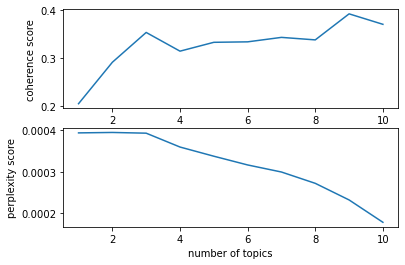

In [9]:
# 불용어 추가 후
import matplotlib.pyplot as plt

x=range(1,11)
plt.subplot(211)
plt.plot(x,coherencesT)
plt.xlabel('number of topics')
plt.ylabel('coherence score')

plt.subplot(212)
plt.plot(x,np.exp(perplexitiesT))
plt.xlabel('number of topics')
plt.ylabel('perplexity score')

Text(0, 0.5, 'perplexity score')

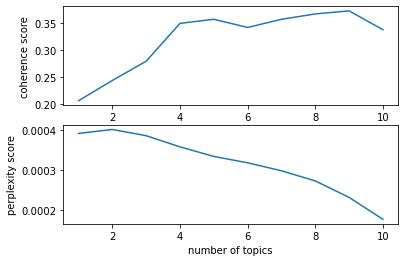

In [24]:
# 불용어 추가 전
import matplotlib.pyplot as plt

x=range(1,11)
plt.subplot(211)
plt.plot(x,coherencesT)
plt.xlabel('number of topics')
plt.ylabel('coherence score')

plt.subplot(212)
plt.plot(x,np.exp(perplexitiesT))
plt.xlabel('number of topics')
plt.ylabel('perplexity score')

토픽 개수는 4,5개가 적절

#### TF-IDF

In [25]:
coherencesTF=[]
perplexitiesTF=[]

for i in range(1,11):

    lda4 = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=i,  passes=30, random_state=2021)
    print('ntopics',i)

    cm = CoherenceModel(model=lda4, texts=token_data, dictionary=dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    print("Coherence",coherence)
    coherencesTF.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexitiesTF.append(lda4.log_perplexity(corpus))

ntopics 1
Coherence 0.22650351207660355
Perplexity:  -7.924686463970899 


ntopics 2
Coherence 0.29276629689009137
Perplexity:  -7.899603399115332 


ntopics 3
Coherence 0.2940274188956736
Perplexity:  -7.9646293812707665 


ntopics 4
Coherence 0.30461451080853064
Perplexity:  -8.055480838391842 


ntopics 5
Coherence 0.3369423829581334
Perplexity:  -8.113241312200902 


ntopics 6
Coherence 0.3248890730430832
Perplexity:  -8.174436634324502 


ntopics 7
Coherence 0.4020556301502946
Perplexity:  -8.235341907862647 


ntopics 8
Coherence 0.3363316524937743
Perplexity:  -8.322341604663142 


ntopics 9
Coherence 0.36498030373796875
Perplexity:  -8.491257344890311 


ntopics 10
Coherence 0.3422736655505446
Perplexity:  -8.792340926805485 




Text(0, 0.5, 'perplexity score')

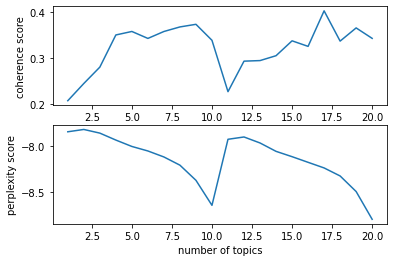

In [29]:
import matplotlib.pyplot as plt

x=range(1,21)
plt.subplot(211)

plt.plot(x,coherencesT)
plt.xlabel('number of topics')
plt.ylabel('coherence score')

plt.subplot(212)
plt.plot(x,perplexitiesT)

plt.xlabel('number of topics')
plt.ylabel('perplexity score')

## 3. 최적모델 시각화

In [10]:
model3 = LdaModel(corpus, id2word=dictionary, num_topics=3,  passes=30, random_state=2021)

In [11]:
topics = model3.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.039*"작품" + 0.033*"스토리" + 0.026*"작화" + 0.020*"캐릭터" + 0.020*"느낌" + 0.018*"원작" + 0.017*"내용" + 0.013*"연출" + 0.012*"부분" + 0.012*"전개"')
(1, '0.028*"주인공" + 0.016*"사람" + 0.012*"세계" + 0.007*"현실" + 0.007*"여자" + 0.007*"여주" + 0.006*"이야기" + 0.006*"모습" + 0.006*"인간" + 0.005*"이해"')
(2, '0.023*"더빙" + 0.020*"성우" + 0.011*"자막" + 0.011*"목소리" + 0.008*"눈물" + 0.007*"노래" + 0.007*"얼굴" + 0.006*"추억" + 0.006*"처음" + 0.006*"행복"')


In [12]:
model4 = LdaModel(corpus, id2word=dictionary, num_topics=4,  passes=30, random_state=2021)

In [13]:
topics = model4.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.039*"작품" + 0.034*"스토리" + 0.027*"작화" + 0.022*"캐릭터" + 0.021*"느낌" + 0.019*"원작" + 0.018*"내용" + 0.014*"연출" + 0.013*"부분" + 0.012*"전개"')
(1, '0.035*"주인공" + 0.016*"사람" + 0.015*"세계" + 0.009*"현실" + 0.008*"여자" + 0.008*"이야기" + 0.008*"여주" + 0.008*"성장" + 0.007*"인간" + 0.006*"모습"')
(2, '0.034*"더빙" + 0.016*"자막" + 0.010*"사람" + 0.009*"힐링" + 0.008*"아이돌" + 0.007*"결제" + 0.007*"눈물" + 0.006*"리뷰" + 0.006*"백합" + 0.006*"방영"')
(3, '0.034*"성우" + 0.019*"목소리" + 0.018*"노래" + 0.011*"오프닝" + 0.011*"얼굴" + 0.010*"추억" + 0.009*"아이" + 0.009*"연기" + 0.008*"장면" + 0.007*"이다"')


In [16]:
model5 = LdaModel(corpus, id2word=dictionary, num_topics=5,  passes=30, random_state=2021)

In [17]:
topics = model5.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.037*"작품" + 0.036*"스토리" + 0.028*"작화" + 0.022*"캐릭터" + 0.022*"느낌" + 0.020*"원작" + 0.018*"내용" + 0.014*"연출" + 0.013*"부분" + 0.013*"전개"')
(1, '0.034*"주인공" + 0.020*"사람" + 0.018*"세계" + 0.010*"현실" + 0.010*"작품" + 0.010*"이야기" + 0.010*"여주" + 0.009*"인간" + 0.008*"작가" + 0.008*"성장"')
(2, '0.043*"더빙" + 0.021*"자막" + 0.012*"사람" + 0.010*"아이돌" + 0.009*"결제" + 0.007*"귀여워" + 0.007*"번역" + 0.007*"성인" + 0.007*"행복" + 0.007*"하네"')
(3, '0.041*"성우" + 0.022*"목소리" + 0.021*"노래" + 0.013*"오프닝" + 0.013*"얼굴" + 0.012*"추억" + 0.011*"연기" + 0.008*"방영" + 0.008*"이다" + 0.007*"시절"')
(4, '0.018*"여자" + 0.014*"남자" + 0.014*"주인공" + 0.011*"게임" + 0.010*"백합" + 0.008*"감성" + 0.008*"치유" + 0.007*"주가" + 0.007*"마력" + 0.007*"친구"')
